In [34]:
from denoisers.NLM import *
from PIL import *
from iterative_algorithms import *
from forward_models import *
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import scipy.ndimage

import pandas as pd

from scipy.ndimage import zoom

plt.rcParams['figure.figsize'] = (2,2)  # Width, Height in inches




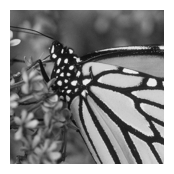

In [35]:
#read the image
image = Image.open("./images/5.png")
#convert the image to a numpy array
image = np.array(image)
#to double
image = image.astype(np.float64)
#to range 0 to 1P_operator
image = image/255.0


plt.imshow(image, cmap='gray')
plt.axis('off')  # Hide axis
plt.show()

In [36]:

# -------- BLURRING -------- #
A_function = gaussian_blurring
A_kwargs = {'radius': 12, 'sigma': 1.6}
A_function_adjoint = gaussian_blurring
A_adjoint_kwargs = A_kwargs
# -------- END BLURRING -------- #

In [37]:
# b0 = A_function(image, **A_kwargs)
b0 = A_function(image, **A_kwargs) 

np.random.seed(7)
b0 = b0 + np.random.normal(0, 0.03, b0.shape)
input_image = b0.copy()

In [38]:
#FISTA
def fista(input_image,start_image,denoiser,denoiser_kwargs,step_size = 0.9,num_iter=1000):
    x_old = start_image.copy()
    y = start_image.copy()
    # N = [calc_cost(x_old,input_image)]
    N = []
    all_iters = []
    t=1
    eta = step_size

    for i in range(num_iter):
        x = P_operator(y,denoiser=DSG_NLM,denoiser_kwargs=denoiser_kwargs,A_function=A_function,
                       A_kwargs=A_kwargs,A_function_adjoint=A_function_adjoint,
                       A_adjoint_kwargs=A_adjoint_kwargs,eta=eta) + eta*denoiser(A_function_adjoint(input_image,
                                                                                            **A_adjoint_kwargs),**denoiser_kwargs)
        t_new = 0.5*(1+np.sqrt(1+4*t**2))
        alpha = (t-1)/t_new
        # alpha = 1 - 1/np.log(i+2)
        # alpha=0.0
        y = x + alpha*(x-x_old)
      
        all_iters.append(x_old)
        x_old = x
        t = t_new
       

    return x,N,all_iters




In [39]:
def restoration_deblur(input_image,original_image):
    #generate guide image for deblurring with 10 iterations warmup
    #use different patch sizes, window sizes and sigmas combinations
    #to find the best guide image
    #but using more than one combination will increase the time
    possible_patch = [1]
    possible_window = [3,5]
    possible_sigma = [15,30]


    best_ssim = 0
    #generate guide image for deblurring with 10 iterations warmup
    for pat in possible_patch:
        for win in possible_window:
            for sig in possible_sigma:
                if pat > win:
                    continue

                dn = {}
                dn["patch_rad"] = pat
                dn["window_rad"] = win
                dn["sigma"] = sig/255.0
                dn["guide_image"] = b0.copy()
                start_image = b0.copy()

                
                
                xx,N,all_iters = fista(input_image,start_image,DSG_NLM,dn,step_size=0.9,num_iter=10)
                    # plt.imshow(x, cmap='gray')
                    # plt.axis('off')
                    # plt.show()

                
                ssim_index = ssim(xx, original_image, data_range=1.0)
                psnr_value = psnr(xx, original_image, data_range=1.0)

                print("Patch size:",pat)
                print("Window size:",win)
                print("Sigma:",sig)
                print("SSIM:",ssim_index)
                print("PSNR:",psnr_value)
                print("----------------------")

                if ssim_index > best_ssim:
                    best_ssim = ssim_index
                    best_p = pat
                    best_w = win
                    best_s = sig
                    gmm = xx

    print("Guide image generated")
    print("----------------------")
    print("|| best patch size:",best_p)
    print("|| best window size:",best_w)
    print("|| best sigma:",best_s)
    print("|| best ssim:",best_ssim)
    print(" ----------------------")


        # ----- GUIDE IMAGE GENERATED ----- #


    #----- RESTORATION ----- #
    #With guide image generated, restore the image ----------------- #

    for pat in possible_patch:
        for win in possible_window:
            for sig in possible_sigma:
                if pat > win:
                    continue

                dn = {}
                dn["patch_rad"] = pat
                dn["window_rad"] = win
                dn["sigma"] = sig/255.0
                dn["guide_image"] = gmm.copy()
                start_image = gmm.copy()

                
                
                xx,N,all_iters = fista(input_image,start_image,DSG_NLM,dn,step_size=0.9,num_iter=10)
                    # plt.imshow(x, cmap='gray')
                    # plt.axis('off')
                    # plt.show()

                
                ssim_index = ssim(xx, original_image, data_range=1.0)
                psnr_value = psnr(xx, original_image, data_range=1.0)

                print("Patch size:",pat)
                print("Window size:",win)
                print("Sigma:",sig)
                print("SSIM:",ssim_index)
                print("PSNR:",psnr_value)
                print("----------------------")

                if ssim_index > best_ssim:
                    best_ssim = ssim_index
                    best_p = pat
                    best_w = win
                    best_s = sig
                    best_restored = xx

    print("Image restored")
    print("----------------------")

    print("|| best patch size:",best_p)
    print("|| best window size:",best_w)
    print("|| best sigma:",best_s)
    print("|| best ssim:",best_ssim)
    print(" ----------------------")


    return best_restored,gmm



In [40]:
restoration,_ = restoration_deblur(input_image,image)

Patch size: 1
Window size: 3
Sigma: 15
SSIM: 0.8020488063925381
PSNR: 25.6225862101917
----------------------
Patch size: 1
Window size: 3
Sigma: 30
SSIM: 0.8686649360065131
PSNR: 26.63852731221359
----------------------
Patch size: 1
Window size: 5
Sigma: 15
SSIM: 0.8295044994210666
PSNR: 25.888581708979636
----------------------
Patch size: 1
Window size: 5
Sigma: 30
SSIM: 0.866163077853449
PSNR: 26.597646415377334
----------------------
Guide image generated
----------------------
|| best patch size: 1
|| best window size: 3
|| best sigma: 30
|| best ssim: 0.8686649360065131
 ----------------------
Patch size: 1
Window size: 3
Sigma: 15
SSIM: 0.8808335928860261
PSNR: 27.15058209738539
----------------------
Patch size: 1
Window size: 3
Sigma: 30
SSIM: 0.877537574160804
PSNR: 27.20822692480246
----------------------
Patch size: 1
Window size: 5
Sigma: 15
SSIM: 0.8811078984508228
PSNR: 27.176483260673713
----------------------
Patch size: 1
Window size: 5
Sigma: 30
SSIM: 0.87480432061

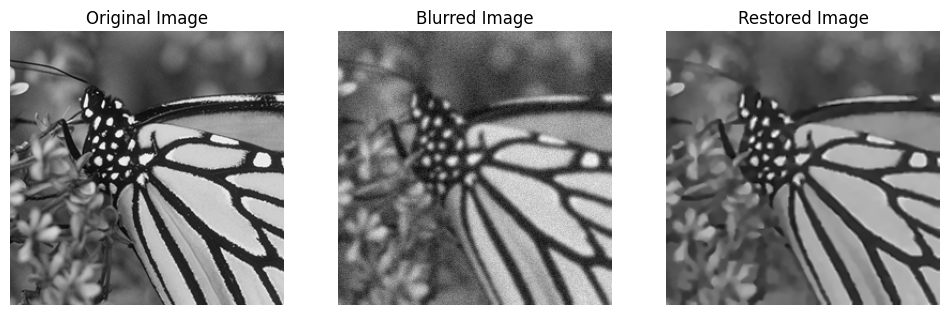

In [41]:
fig, axs = plt.subplots(1, 3,figsize=(12, 4))
axs[0].imshow(image, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original Image')
axs[1].imshow(b0, cmap='gray')
axs[1].axis('off')
axs[1].set_title('Blurred Image')
axs[2].imshow(restoration, cmap='gray')
axs[2].axis('off')
axs[2].set_title('Restored Image')
plt.show()